Until now we only created models which gets 1D input.  
So let's start to do real computer vision.

In [11]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [12]:
# Hyper parameters
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001

We use MNIST again but this time we will use it as 2D images instead of 1D vectors.
Also we will use a validation set which you should do in your term projects too.

In [39]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='data',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data',
                                          train=False, 
                                          transform=transforms.ToTensor())

train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                           batch_size=batch_size, 
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=val_set,
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)
print(f"Train size: {len(train_set)}, Validation size: {len(val_set)}, Test size: {len(test_dataset)}")

Train size: 50000, Validation size: 10000, Test size: 10000


Always visualize your dataset to be sure about your input and output.   
We don't do that in this tutorials but checking input and output should be your first thing to do.

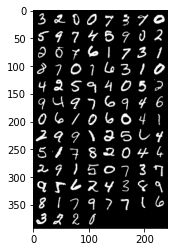

tensor([3, 2, 0, 0, 7, 3, 7, 0, 5, 9, 7, 4, 5, 9, 0, 2, 2, 0, 7, 6, 1, 7, 3, 1,
        8, 7, 0, 7, 6, 3, 1, 0, 4, 2, 5, 9, 4, 0, 5, 2, 9, 4, 9, 7, 6, 9, 4, 6,
        0, 6, 1, 0, 6, 0, 4, 1, 2, 9, 9, 1, 2, 5, 6, 4, 5, 1, 7, 8, 2, 0, 4, 4,
        2, 9, 1, 5, 0, 7, 3, 7, 9, 5, 6, 2, 4, 3, 8, 9, 8, 1, 7, 9, 7, 7, 1, 6,
        3, 2, 2, 0])


In [40]:
# When iteration starts, queue and thread start to load data from files.
data_iter = iter(train_loader)

# Mini-batch images and labels.
images, labels = data_iter.next()

import matplotlib.pyplot as plt
import numpy as np

grid_imgs = torchvision.utils.make_grid(images)
npimg = grid_imgs.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()
print(labels)

In [41]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

After this point everything is same with before.  
Only our input data dimension changed so model, loss and loaders change. Rest is the same as 1D case.

One thing to note here. We don't use validation in the tutorials but validation is the same with test code. You shouldn't update gradients 

In [42]:
model = ConvNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    
    # At each epoch we perform validation to see whether our model overfit the data or not
    # We shouldn't learn anything from validation data so it looks like we are testing
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in validation_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Validation Accuracy of the model on the 10000 validation images: {100 * correct / total} ")

Epoch [1/5], Step [100/500], Loss: 0.0867
Epoch [1/5], Step [200/500], Loss: 0.0422
Epoch [1/5], Step [300/500], Loss: 0.0520
Epoch [1/5], Step [400/500], Loss: 0.0300
Epoch [1/5], Step [500/500], Loss: 0.0447
Validation Accuracy of the model on the 10000 validation images: 98.25 
Epoch [2/5], Step [100/500], Loss: 0.1369
Epoch [2/5], Step [200/500], Loss: 0.0408
Epoch [2/5], Step [300/500], Loss: 0.0346
Epoch [2/5], Step [400/500], Loss: 0.0125
Epoch [2/5], Step [500/500], Loss: 0.1024
Validation Accuracy of the model on the 10000 validation images: 98.52 
Epoch [3/5], Step [100/500], Loss: 0.0323
Epoch [3/5], Step [200/500], Loss: 0.0102
Epoch [3/5], Step [300/500], Loss: 0.1252
Epoch [3/5], Step [400/500], Loss: 0.0117
Epoch [3/5], Step [500/500], Loss: 0.0328
Validation Accuracy of the model on the 10000 validation images: 98.77 
Epoch [4/5], Step [100/500], Loss: 0.0036
Epoch [4/5], Step [200/500], Loss: 0.0405
Epoch [4/5], Step [300/500], Loss: 0.0709
Epoch [4/5], Step [400/500],

In [43]:
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Test Accuracy of the model on the 10000 test images: {100 * correct / total} ")

Test Accuracy of the model on the 10000 test images: 99.05 


## Residual Networks (ResNet)

So until now we built basic networks.  
Let's see how we can build more complex networks like ResNet.
To create these complex networks you need a good modularization. It helps you to both debug it easily and write it beautifully.

We first create a 3x3 convolution layer to not use the same long function definition over and over again.

<img src="img/resnet.png" width="800" height="400">

ResNet-34 (from K. He et al. “Deep Residual Learning”)!



In [44]:
# 3x3 convolution
# Takes input, output channels and stride
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

Then we create the main block of the ResNet. This block will be used over and over again inside the network.


In [45]:
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

Now we create our model using this Residual Block

In [46]:
# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

We are creating a smaller one for CIFAR-10 but by changing layer list below you can increase the size of the network. So modularization makes your life easier.

In [47]:
model = ResNet(ResidualBlock, [2, 2, 2]).to(device)
print(model)

ResNet(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [50]:
# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='data/',
                                            train=False, 
                                            transform=transforms.ToTensor())

train_set, val_set = torch.utils.data.random_split(train_dataset, [int(len(train_dataset)*0.9), int(len(train_dataset)*0.1)])


# Data loader
train_loader = torch.utils.data.DataLoader(dataset= train_set,
                                           batch_size=batch_size,
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset= val_set,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset= test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

print(f"Train size: {len(train_set)}, Validation size: {len(val_set)}, Test size: {len(test_dataset)}")

Files already downloaded and verified
Train size: 45000, Validation size: 5000, Test size: 10000


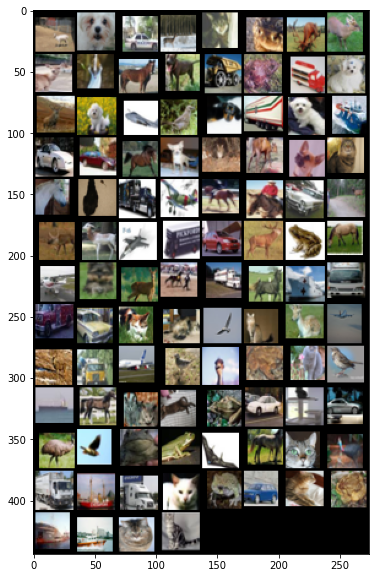

tensor([4, 5, 1, 4, 3, 6, 4, 4, 4, 2, 7, 5, 9, 6, 9, 5, 4, 5, 0, 2, 5, 9, 5, 8,
        1, 1, 7, 5, 3, 4, 5, 3, 7, 3, 9, 0, 7, 7, 1, 4, 4, 4, 0, 9, 1, 4, 6, 7,
        0, 5, 4, 7, 9, 7, 8, 9, 9, 1, 3, 3, 2, 3, 4, 0, 4, 9, 0, 2, 2, 6, 3, 2,
        8, 7, 3, 3, 6, 1, 3, 1, 2, 2, 6, 6, 0, 7, 3, 2, 9, 8, 9, 3, 6, 1, 3, 6,
        8, 8, 3, 3])


In [54]:
# When iteration starts, queue and thread start to load data from files.
data_iter = iter(train_loader)

# Mini-batch images and labels.
images, labels = data_iter.next()

grid_imgs = torchvision.utils.make_grid(images)
npimg = grid_imgs.numpy()
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()
print(labels)

We use the same training and testing loop

In [51]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    
    # At each epoch we perform validation to see whether our model overfit the data or not
    # We shouldn't learn anything from validation data so it looks like we are testing
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in validation_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f"Validation Accuracy of the model on the 10000 validation images: {100 * correct / total} ")
        
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Test Accuracy of the model on the 10000 test images: {100 * correct / total} ")

Epoch [1/5], Step [100/450] Loss: 1.0932
Epoch [1/5], Step [200/450] Loss: 0.8456
Epoch [1/5], Step [300/450] Loss: 0.9055
Epoch [1/5], Step [400/450] Loss: 0.9873
Validation Accuracy of the model on the 10000 validation images: 64.66 
Epoch [2/5], Step [100/450] Loss: 1.0771
Epoch [2/5], Step [200/450] Loss: 0.8811
Epoch [2/5], Step [300/450] Loss: 0.9175
Epoch [2/5], Step [400/450] Loss: 0.8322
Validation Accuracy of the model on the 10000 validation images: 69.66 
Epoch [3/5], Step [100/450] Loss: 1.0170
Epoch [3/5], Step [200/450] Loss: 0.7888
Epoch [3/5], Step [300/450] Loss: 0.9139
Epoch [3/5], Step [400/450] Loss: 0.7223
Validation Accuracy of the model on the 10000 validation images: 73.26 
Epoch [4/5], Step [100/450] Loss: 0.7191
Epoch [4/5], Step [200/450] Loss: 0.7898
Epoch [4/5], Step [300/450] Loss: 0.5414
Epoch [4/5], Step [400/450] Loss: 0.6601
Validation Accuracy of the model on the 10000 validation images: 74.22 
Epoch [5/5], Step [100/450] Loss: 0.5460
Epoch [5/5], St

In [52]:
# Save the model checkpoint
torch.save(model.state_dict(), 'resnet.ckpt')